In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Import necessary packages.
import numpy as np
import pandas as pd
import os
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from PIL import Image
# "ConcatDataset" and "Subset" are possibly useful when doing semi-supervised learning.
from torch.utils.data import ConcatDataset, DataLoader, Subset, Dataset
from torchvision.datasets import DatasetFolder, VisionDataset

# This is for the progress bar.
from tqdm.auto import tqdm
import random
from random import sample, seed

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

In [4]:
myseed = 6666  # set a random seed for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(myseed)
torch.manual_seed(myseed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(myseed)

# Rename pictures

In [ ]:
# path = '/content/drive/MyDrive/Colab Notebooks/task23/task2_task3/'
# comp2pakage_df = pd.read_csv(os.path.join(path, 'comp_type_to_pakage_type.csv'))
# train_df = pd.read_csv(os.path.join(path, 'training/training_set_df.csv'))
# target_comptype = comp2pakage_df[comp2pakage_df['package_type'].\
#                                  isin(['C0201','C0402','C0603','C0805','C3528','R0201','R0402','R0603'])]\
#                                  ['comp_type'].tolist()
# train_df = train_df[train_df['comp_type'].isin(target_comptype)]
# train_df['compid'] = train_df['compid'].astype('str')
# dic = {'NG':'1_', 'OK':'0_'}
# train_df['label2'] = train_df['label'].map(dic)
# train_df.insert(1, 'compid2', train_df['label2'] + train_df['compid'])

# path = '/content/drive/MyDrive/Colab Notebooks/task23/task2_task3/training/pic/'
# for x, y in zip(train_df['compid'], train_df['compid2']):
#   old_name = path + x + '.jpg'
#   new_name = path + y + '.jpg'
#   # os.rename(old_name, new_name) # not repeat run

# Padding

In [ ]:
# Find the biggest length and width
path = '/content/drive/MyDrive/Colab Notebooks/task23/task2_task3/training/pic/'
fname_lst = os.listdir(path)

w_lst = []
h_lst = []
for fname in tqdm(fname_lst):
  im = Image.open(os.path.join(path, fname))
  # print(im.size) # (W,H)
  w, h = im.size
  w_lst.append(w)
  h_lst.append(h)

In [ ]:
import statistics

print('width: min', min(w_lst), 'max', max(w_lst), 'median', statistics.median(w_lst), 'mean', statistics.mean(w_lst))
print('height: min', min(h_lst), 'max', max(h_lst), 'median', statistics.median(h_lst), 'mean', statistics.mean(h_lst))

width: min 60 max 1410 median 188 mean 335.84816820643516
height: min 56 max 1549 median 186 mean 321.24867792290536


In [ ]:
image = Image.open(os.path.join(path, fname_lst[200]))
image.show()

In [ ]:
# Read image sample
image = Image.open(os.path.join(path, fname_lst[200]))
w, h = image.size # (W, H)
print(image.size)
print('widht', w, 'height', h)

# Method1: independent padding to square
# padding_size = h - w
# print(padding_size)
# add_0 = abs(padding_size)//2
# if h > w:
#   pad = transforms.Pad((add_0, 0, abs(padding_size)-add_0, 0)) # left, top, right, down
# else:
#   pad = transforms.Pad((0, add_0, 0, abs(padding_size)-add_0))

# Method2: padding to the biggest length and width
w_max = 1410 
h_max = 1549
w_dif = w_max - w
h_dif = h_max - h
pad = transforms.Pad((w_dif//2, h_dif//2, w_dif-w_dif//2, h_dif-h_dif//2))

# transform sample
transform = transforms.Compose([
    pad, 
    transforms.Resize((224,224)),
    transforms.ToTensor()
])
padded_image = transform(image)
plt.imshow(padded_image.permute(1,2,0)) # padded_image.shape # (C, H, W)

# Show OK/NG picture

In [ ]:
# demo transforms
path = '/content/drive/MyDrive/Colab Notebooks/task23/task2_task3/training/pic/'
fname_lst = os.listdir(path)

ok_fname_lst = []
fail_fname_lst = []
for x in fname_lst:
  if '1_' in x:
    fail_fname_lst.append(x)
  if '0_' in x:
    ok_fname_lst.append(x)

In [ ]:
for fname in sample(fail_fname_lst, 10): # fail_fname_lst/ ok_fname_lst
    image = Image.open(os.path.join(path, fname))
    image.show()  

# Transforms

In [ ]:
# Transform sample
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomRotation(degrees=(89.99,90.01)),
    transforms.ColorJitter(brightness=.5,hue=0.5),
    transforms.RandomInvert(),
    transforms.ToTensor()
])
im = Image.open(os.path.join(path, ok_fname_lst[0]))
im.show()

im2 = transform(im)
plt.imshow(im2.permute(1,2,0))

In [ ]:
# Normally, We don't need augmentations in testing and validation.
# All we need here is to resize the PIL image and transform it into Tensor.
test_tfm = transforms.Compose([
    # transforms.Resize((128, 128)), # My_CNN
    transforms.Resize((224, 224)), # resnet50, effecientNet
    transforms.ToTensor(),
])

# Training
# case1: no trans
train1_tfm = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# case2: Gaussain noise, Autocontrast and Sharpness
# train1_tfm = transforms.Compose([
#     transforms.Resize((128, 128)),
#     transforms.GaussianBlur(kernel_size=3),
#     transforms.ToTensor(),
# ])
# train2_tfm = transforms.Compose([
#     transforms.Resize((128, 128)),
#     transforms.RandomAutocontrast(p=0.5),
#     transforms.RandomAdjustSharpness(sharpness_factor=2, p=0.5),
#     transforms.ToTensor(),
# ])

# Datasets

In [ ]:
seed(110024519)
train_index = sample(range(12224), 10000)
valid_index = list(set(range(12224)) - set(train_index))

print(len(train_index))
print(len(valid_index))

10000
2224


In [ ]:
class Task23Dataset(Dataset):

    def __init__(self, path, tfm=test_tfm, evaluation=False, train_or_valid=None): 
        super(Task23Dataset).__init__()
        self.path = path
        if evaluation == False:  # training
            self.files = sorted([os.path.join(path,x) for x in os.listdir(path) if x.endswith(".jpg") and '_' in x])
        else:  # testing
            self.files = sorted([os.path.join(path,x) for x in os.listdir(path) if x.endswith(".jpg")])

        if train_or_valid == 'train':
          self.files = list(np.array(self.files)[train_index])
        if train_or_valid == 'valid':
          self.files = list(np.array(self.files)[valid_index])
          
        print(f"One {path} sample",self.files[0])
        self.transform = tfm
        
  
    def __len__(self):
        return len(self.files)
  
    def __getitem__(self, idx):
        fname = self.files[idx]
        im = Image.open(fname)
        # trans = self.my_padding(im) # depend on image to padding 
        # im = trans(im) # run padding
        im = self.transform(im)
        try:
            label = int(fname.split("/")[-1].split("_")[0])
        except:
            label = -1 # test has no label
        return im, label

    
    def my_padding(self, im):
      w, h = im.size # (W,H)
      
      # independent padding to the square of each image
      # padding_size = h - w 
      # add_0 = abs(padding_size) // 2
      # if padding_size > 0: # h > w
      #   pad = transforms.Pad((add_0, 0, abs(padding_size)-add_0, 0)) # left, top, right, down
      # else:
      #   pad = transforms.Pad((0, add_0, 0, abs(padding_size)-add_0))

      # Padding each image to the biggest length and width in all images
      w_max = 1410 
      h_max = 1549
      w_dif = w_max - w
      h_dif = h_max - h
      pad = transforms.Pad((w_dif//2, h_dif//2, w_dif-w_dif//2, h_dif-h_dif//2))

      return transforms.Compose([pad])



# Classifier model structure

In [ ]:
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        # torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        # torch.nn.MaxPool2d(kernel_size, stride, padding)
        # input 維度 [3, 128, 128]
        self.cnn = nn.Sequential(
            nn.Conv2d(3, 64, 3, 1, 1),  # [64, 128, 128]
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.1),
            nn.MaxPool2d(2, 2, 0),      # [64, 64, 64]
            # nn.Dropout(0.5),

            nn.Conv2d(64, 128, 3, 1, 1), # [128, 64, 64]
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.1),
            nn.MaxPool2d(2, 2, 0),      # [128, 32, 32]
            # nn.Dropout(0.5),

            nn.Conv2d(128, 256, 3, 1, 1), # [256, 32, 32]
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.1),
            nn.MaxPool2d(2, 2, 0),      # [256, 16, 16]
            # nn.Dropout(0.5),

            nn.Conv2d(256, 512, 3, 1, 1), # [512, 16, 16]
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.1),
            nn.MaxPool2d(2, 2, 0),       # [512, 8, 8]
            # nn.Dropout(0.5),
            
            nn.Conv2d(512, 512, 3, 1, 1), # [512, 8, 8]
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.1),
            nn.MaxPool2d(2, 2, 0),       # [512, 4, 4]
            # nn.Dropout(0.5)

        )
        self.fc = nn.Sequential(
            nn.Linear(512*4*4, 1024),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.5),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.5),
            nn.Linear(512, 2) # 2 class
        )

    def forward(self, x):
        out = self.cnn(x)
        out = out.view(out.size()[0], -1)
        return self.fc(out)

# Pre-train model
ResNet50 and EffecientNet_v2_s

In [10]:
import torchvision.models as models

# ResNet50
model = models.resnet50(pretrained=True)
model.fc = nn.Linear(in_features=model.fc.in_features, out_features=2)

# EffecientNet
# model = models.efficientnet_v2_s(pretrained=True)
# feature_model = list(model.classifier.children())
# feature_model.pop()
# feature_model.append(nn.Linear(in_features=model.classifier[1].in_features, out_features=2))
# model.classifier = nn.Sequential(*feature_model)

#
model

# Extract features from an input image
input_image = torch.randn(1, 3, 224, 224)
features = model(input_image)
features.shape


/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 321MB/s]


torch.Size([1, 2])

# Load data

In [ ]:
batch_size = 64
dataset_dir = '/content/drive/MyDrive/Colab Notebooks/task23/task2_task3/training/pic/'
# Construct datasets.
# The argument "loader" tells how torchvision reads the data.
train_set1 = Task23Dataset(dataset_dir, tfm=train1_tfm, train_or_valid='train')
# train_set2 = Task23Dataset(dataset_dir, tfm=train2_tfm, train_or_valid='train')
# train_set = ConcatDataset([train_set1, train_set2])
train_loader = DataLoader(train_set1, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True) # train_set1 / train_set
valid_set = Task23Dataset(dataset_dir, tfm=test_tfm, train_or_valid='valid')
valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)

print(len(train_set1))
print(len(valid_set))

One /content/drive/MyDrive/Colab Notebooks/task23/task2_task3/training/pic/ sample /content/drive/MyDrive/Colab Notebooks/task23/task2_task3/training/pic/0_45301474.jpg
One /content/drive/MyDrive/Colab Notebooks/task23/task2_task3/training/pic/ sample /content/drive/MyDrive/Colab Notebooks/task23/task2_task3/training/pic/1_22833872.jpg
10000
2224


In [ ]:
im = train_set1[50][0]
print(im.shape)
plt.imshow(im.permute(1,2,0))

# Model traning

In [ ]:
import torch.optim.lr_scheduler as lr_scheduler

In [ ]:
# "cuda" only when GPUs are available.
device = "cuda" if torch.cuda.is_available() else "cpu" 

# The number of training epochs and patience.
n_epochs = 15
patience = 300 # If no improvement in 'patience' epochs, early stop

# Initialize a model, and put it on the device specified.
# model = Classifier().to(device)

# resnet50
pre_model = models.resnet50(pretrained=True)
pre_model.fc = nn.Linear(in_features=pre_model.fc.in_features, out_features=2)
model = pre_model.to(device)

# efficientnet_v2_s
# pre_model = models.efficientnet_v2_s(pretrained=True)
# feature_model = list(pre_model.classifier.children())
# feature_model.pop()
# feature_model.append(nn.Linear(in_features=pre_model.classifier[1].in_features, out_features=2))
# pre_model.classifier = nn.Sequential(*feature_model)
# model = pre_model.to(device)

# For the classification task, we use cross-entropy as the measurement of performance.
criterion = nn.CrossEntropyLoss()

# Initialize optimizer, you may fine-tune some hyperparameters such as learning rate on your own.
optimizer = torch.optim.Adam(model.parameters(), lr=0.0003, weight_decay=1e-5) 
# scheduler = lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.1) # performance is bad

# Initialize trackers, these are not parameters and should not be changed
stale = 0
best_acc = 0

for epoch in range(n_epochs):

    # ---------- Training ----------
    # Make sure the model is in train mode before training.
    model.train()

    # These are used to record information in training.
    train_loss = []
    train_accs = []

    for batch in tqdm(train_loader):

        # A batch consists of image data and corresponding labels.
        imgs, labels = batch
        #imgs = imgs.half()
        #print(imgs.shape,labels.shape)

        # Forward the data. (Make sure data and model are on the same device.)
        logits = model(imgs.to(device)) # 2x1

        # Calculate the cross-entropy loss.
        # We don't need to apply softmax before computing cross-entropy as it is done automatically.
        loss = criterion(logits, labels.to(device))

        # Gradients stored in the parameters in the previous step should be cleared out first.
        optimizer.zero_grad()

        # Compute the gradients for parameters.
        loss.backward()

        # Clip the gradient norms for stable training.
        grad_norm = nn.utils.clip_grad_norm_(model.parameters(), max_norm=10)

        # Update the parameters with computed gradients.
        optimizer.step()
        # scheduler.step()

        # Compute the accuracy for current batch.
        acc = (logits.argmax(dim=-1) == labels.to(device)).float().mean()

        # Record the loss and accuracy.
        train_loss.append(loss.item())
        train_accs.append(acc)
        
    train_loss = sum(train_loss) / len(train_loss)
    train_acc = sum(train_accs) / len(train_accs)

    # Print the information.
    print(f"[ Train | {epoch + 1:03d}/{n_epochs:03d} ] loss = {train_loss:.5f}, acc = {train_acc:.5f}")

    # ---------- Validation ----------
    # Make sure the model is in eval mode so that some modules like dropout are disabled and work normally.
    model.eval()

    # These are used to record information in validation.
    valid_loss = []
    valid_accs = []

    pred_label_lst = []
    true_label_lst = []
    missing_rate_lst = []
    benefit_lst = []

    pred_prob_lst = []


    # Iterate the validation set by batches.
    for batch in tqdm(valid_loader):

        # A batch consists of image data and corresponding labels.
        imgs, labels = batch
        #imgs = imgs.half()

        # We don't need gradient in validation.
        # Using torch.no_grad() accelerates the forward process.
        with torch.no_grad():
            logits = model(imgs.to(device))

        # We can still compute the loss (but not the gradient).
        loss = criterion(logits, labels.to(device))

        # Compute the accuracy for current batch.
        acc = (logits.argmax(dim=-1) == labels.to(device)).float().mean()
        
        # Compute the confusion matrix
        pred_label_lst.append(logits.argmax(dim=-1).cpu().tolist())
        true_label_lst.append(labels.tolist())
        # print(pred_label_lst)
        # print(true_label_lst)

        # softmax 
        softmax_fun = nn.Softmax(dim=1)
        output = softmax_fun(logits)
        pred_prob_lst.append(output.cpu().tolist())

        # Record the loss and accuracy.(add missing_rate and benefit.)
        valid_loss.append(loss.item())
        valid_accs.append(acc)


    # The average loss and accuracy for entire validation set is the average of the recorded values.
    valid_loss = sum(valid_loss) / len(valid_loss)
    valid_acc = sum(valid_accs) / len(valid_accs)

    pred_label_lst = sum(pred_label_lst, []) # un inner list
    true_label_lst = sum(true_label_lst, []) # un inner list
    TN, FP, FN, TP = confusion_matrix(true_label_lst, pred_label_lst).ravel()
    print('TN =',TN, 'FP =', FP, 'FN =', FN, 'TP =', TP) 
    missing_rate = FN / (TP+FN)
    benefit = (FN+TN) / (TP+FP+FN+TN)

    # Print the information.
    print(f"[ Valid | {epoch + 1:03d}/{n_epochs:03d} ] loss = {valid_loss:.5f}, acc = {valid_acc:.5f}")

    print(f"[ Valid | {epoch + 1:03d}/{n_epochs:03d} ] missing_rate = {missing_rate:.5f}, benefit = {benefit:.5f}")

    # update logs
    if valid_acc > best_acc:
        with open(f"./sample_log.txt","a"):
            print(f"[ Valid | {epoch + 1:03d}/{n_epochs:03d} ] loss = {valid_loss:.5f}, acc = {valid_acc:.5f} -> best")
    else:
        with open(f"./sample_log.txt","a"):
            print(f"[ Valid | {epoch + 1:03d}/{n_epochs:03d} ] loss = {valid_loss:.5f}, acc = {valid_acc:.5f}")


    # save models
    if valid_acc > best_acc:
        print(f"Best model found at epoch {epoch}, saving model")
        torch.save(model.state_dict(), f"/content/drive/MyDrive/Colab Notebooks/task23/sample_resnet50_best_case1.ckpt") # only save best to prevent output memory exceed error
        best_acc = valid_acc
        stale = 0
    else:
        stale += 1
        if stale > patience:
            print(f"No improvment {patience} consecutive epochs, early stopping")
            break

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


  0%|          | 0/157 [00:00<?, ?it/s]

[ Train | 001/015 ] loss = 0.27276, acc = 0.89072


  0%|          | 0/35 [00:00<?, ?it/s]

TN = 1303 FP = 45 FN = 117 TP = 759
[ Valid | 001/015 ] loss = 0.19416, acc = 0.92723
[ Valid | 001/015 ] missing_rate = 0.13356, benefit = 0.63849
[ Valid | 001/015 ] loss = 0.19416, acc = 0.92723 -> best
Best model found at epoch 0, saving model


  0%|          | 0/157 [00:00<?, ?it/s]

[ Train | 002/015 ] loss = 0.14058, acc = 0.94875


  0%|          | 0/35 [00:00<?, ?it/s]

TN = 1323 FP = 25 FN = 91 TP = 785
[ Valid | 002/015 ] loss = 0.14690, acc = 0.94792
[ Valid | 002/015 ] missing_rate = 0.10388, benefit = 0.63579
[ Valid | 002/015 ] loss = 0.14690, acc = 0.94792 -> best
Best model found at epoch 1, saving model


  0%|          | 0/157 [00:00<?, ?it/s]

[ Train | 003/015 ] loss = 0.09029, acc = 0.96825


  0%|          | 0/35 [00:00<?, ?it/s]

TN = 1265 FP = 83 FN = 33 TP = 843
[ Valid | 003/015 ] loss = 0.16087, acc = 0.94777
[ Valid | 003/015 ] missing_rate = 0.03767, benefit = 0.58363
[ Valid | 003/015 ] loss = 0.16087, acc = 0.94777


  0%|          | 0/157 [00:00<?, ?it/s]

[ Train | 004/015 ] loss = 0.05263, acc = 0.98179


  0%|          | 0/35 [00:00<?, ?it/s]

TN = 1245 FP = 103 FN = 43 TP = 833
[ Valid | 004/015 ] loss = 0.22786, acc = 0.93467
[ Valid | 004/015 ] missing_rate = 0.04909, benefit = 0.57914
[ Valid | 004/015 ] loss = 0.22786, acc = 0.93467


  0%|          | 0/157 [00:00<?, ?it/s]

[ Train | 005/015 ] loss = 0.06766, acc = 0.97751


  0%|          | 0/35 [00:00<?, ?it/s]

TN = 1238 FP = 110 FN = 41 TP = 835
[ Valid | 005/015 ] loss = 0.20204, acc = 0.93214
[ Valid | 005/015 ] missing_rate = 0.04680, benefit = 0.57509
[ Valid | 005/015 ] loss = 0.20204, acc = 0.93214


  0%|          | 0/157 [00:00<?, ?it/s]

[ Train | 006/015 ] loss = 0.04918, acc = 0.98209


  0%|          | 0/35 [00:00<?, ?it/s]

TN = 1249 FP = 99 FN = 33 TP = 843
[ Valid | 006/015 ] loss = 0.17351, acc = 0.94048
[ Valid | 006/015 ] missing_rate = 0.03767, benefit = 0.57644
[ Valid | 006/015 ] loss = 0.17351, acc = 0.94048


  0%|          | 0/157 [00:00<?, ?it/s]

[ Train | 007/015 ] loss = 0.03302, acc = 0.98895


  0%|          | 0/35 [00:00<?, ?it/s]

TN = 1322 FP = 26 FN = 82 TP = 794
[ Valid | 007/015 ] loss = 0.18540, acc = 0.95164
[ Valid | 007/015 ] missing_rate = 0.09361, benefit = 0.63129
[ Valid | 007/015 ] loss = 0.18540, acc = 0.95164 -> best
Best model found at epoch 6, saving model


  0%|          | 0/157 [00:00<?, ?it/s]

[ Train | 008/015 ] loss = 0.05901, acc = 0.98119


  0%|          | 0/35 [00:00<?, ?it/s]

TN = 1345 FP = 3 FN = 180 TP = 696
[ Valid | 008/015 ] loss = 0.29549, acc = 0.91771
[ Valid | 008/015 ] missing_rate = 0.20548, benefit = 0.68570
[ Valid | 008/015 ] loss = 0.29549, acc = 0.91771


  0%|          | 0/157 [00:00<?, ?it/s]

[ Train | 009/015 ] loss = 0.02652, acc = 0.99104


  0%|          | 0/35 [00:00<?, ?it/s]

TN = 1297 FP = 51 FN = 42 TP = 834
[ Valid | 009/015 ] loss = 0.14610, acc = 0.95804
[ Valid | 009/015 ] missing_rate = 0.04795, benefit = 0.60207
[ Valid | 009/015 ] loss = 0.14610, acc = 0.95804 -> best
Best model found at epoch 8, saving model


  0%|          | 0/157 [00:00<?, ?it/s]

[ Train | 010/015 ] loss = 0.03458, acc = 0.98855


  0%|          | 0/35 [00:00<?, ?it/s]

TN = 1321 FP = 27 FN = 61 TP = 815
[ Valid | 010/015 ] loss = 0.13856, acc = 0.96057
[ Valid | 010/015 ] missing_rate = 0.06963, benefit = 0.62140
[ Valid | 010/015 ] loss = 0.13856, acc = 0.96057 -> best
Best model found at epoch 9, saving model


  0%|          | 0/157 [00:00<?, ?it/s]

[ Train | 011/015 ] loss = 0.03297, acc = 0.98855


  0%|          | 0/35 [00:00<?, ?it/s]

TN = 1292 FP = 56 FN = 44 TP = 832
[ Valid | 011/015 ] loss = 0.14294, acc = 0.95491
[ Valid | 011/015 ] missing_rate = 0.05023, benefit = 0.60072
[ Valid | 011/015 ] loss = 0.14294, acc = 0.95491


  0%|          | 0/157 [00:00<?, ?it/s]

[ Train | 012/015 ] loss = 0.03639, acc = 0.98736


  0%|          | 0/35 [00:00<?, ?it/s]

TN = 1335 FP = 13 FN = 46 TP = 830
[ Valid | 012/015 ] loss = 0.10903, acc = 0.97366
[ Valid | 012/015 ] missing_rate = 0.05251, benefit = 0.62095
[ Valid | 012/015 ] loss = 0.10903, acc = 0.97366 -> best
Best model found at epoch 11, saving model


  0%|          | 0/157 [00:00<?, ?it/s]

[ Train | 013/015 ] loss = 0.01368, acc = 0.99622


  0%|          | 0/35 [00:00<?, ?it/s]

TN = 1334 FP = 14 FN = 50 TP = 826
[ Valid | 013/015 ] loss = 0.10654, acc = 0.97113
[ Valid | 013/015 ] missing_rate = 0.05708, benefit = 0.62230
[ Valid | 013/015 ] loss = 0.10654, acc = 0.97113


  0%|          | 0/157 [00:00<?, ?it/s]

[ Train | 014/015 ] loss = 0.01275, acc = 0.99592


  0%|          | 0/35 [00:00<?, ?it/s]

TN = 1256 FP = 92 FN = 29 TP = 847
[ Valid | 014/015 ] loss = 0.19989, acc = 0.94568
[ Valid | 014/015 ] missing_rate = 0.03311, benefit = 0.57779
[ Valid | 014/015 ] loss = 0.19989, acc = 0.94568


  0%|          | 0/157 [00:00<?, ?it/s]

[ Train | 015/015 ] loss = 0.01975, acc = 0.99303


  0%|          | 0/35 [00:00<?, ?it/s]

TN = 1346 FP = 2 FN = 81 TP = 795
[ Valid | 015/015 ] loss = 0.14853, acc = 0.96265
[ Valid | 015/015 ] missing_rate = 0.09247, benefit = 0.64164
[ Valid | 015/015 ] loss = 0.14853, acc = 0.96265


# Preprocess testing picture

In [ ]:
path = '/content/drive/MyDrive/Colab Notebooks/task23/task2_task3/testing/'
test_df = pd.read_csv(os.path.join(path, 'testing_set_df.csv'))
test_pic_fname_lst = os.listdir(os.path.join(path, 'pic'))
comp2pakage_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/task23/task2_task3/comp_type_to_pakage_type.csv')
target_comptype = comp2pakage_df[comp2pakage_df['package_type'].\
                                 isin(['C0201','C0402','C0603','C0805','C3528','R0201','R0402','R0603'])]\
                                 ['comp_type'].tolist() # 2418
test_df = test_df[test_df['comp_type'].isin(target_comptype)]
test_df['compid'] = test_df['compid'].astype('str')

dic = {'NG':1, 'OK':0}
test_df['label2'] = test_df['label'].map(dic)

In [ ]:
# # set(test_df['compid']+'.jpg').issubset(set(test_pic_fname_lst)) # True
# ## copy pic to pic_task2
# import shutil
# for x in test_df['compid']:
#   src = f'/content/drive/MyDrive/Colab Notebooks/task23/task2_task3/testing/pic/{x}.jpg'
#   dst = f'/content/drive/MyDrive/Colab Notebooks/task23/task2_task3/testing/pic_task2/{x}.jpg'
#   # shutil.copy(src, dst)

# Testing and prediction
Our model use ensemble learning with resnet50 and effecientNet

In [ ]:
batch_size = 64
dataset_dir = '/content/drive/MyDrive/Colab Notebooks/task23/task2_task3/testing/pic_task2/'
test_set = Task23Dataset(dataset_dir, tfm=test_tfm, evaluation=True)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)

dataset_dir = '/content/drive/MyDrive/Colab Notebooks/task23/task2_task3/training/pic/'
valid_set = Task23Dataset(dataset_dir, tfm=test_tfm, train_or_valid='valid')
valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True) # suffle change to False

One /content/drive/MyDrive/Colab Notebooks/task23/task2_task3/testing/pic_task2/ sample /content/drive/MyDrive/Colab Notebooks/task23/task2_task3/testing/pic_task2/58672750.jpg
One /content/drive/MyDrive/Colab Notebooks/task23/task2_task3/training/pic/ sample /content/drive/MyDrive/Colab Notebooks/task23/task2_task3/training/pic/1_22833872.jpg


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu" 
# my_cnn
# model_best = Classifier().to(device)

# resnet50
pre_model = models.resnet50(pretrained=True)
pre_model.fc = nn.Linear(in_features=pre_model.fc.in_features, out_features=2)
model = pre_model.to(device)
model_best_resnet50 = pre_model.to(device)

# efficientnet_v2_s
pre_model = models.efficientnet_v2_s(pretrained=True)
feature_model = list(pre_model.classifier.children())
feature_model.pop()
feature_model.append(nn.Linear(in_features=pre_model.classifier[1].in_features, out_features=2))
pre_model.classifier = nn.Sequential(*feature_model)
model_best_efficientnet = pre_model.to(device)

# model_best.load_state_dict(torch.load('/content/drive/MyDrive/Colab Notebooks/task23/sample_resnet50_best_case1.ckpt'))
# model_best.eval()
model_best_resnet50.load_state_dict(torch.load('/content/drive/MyDrive/Colab Notebooks/task23/sample_resnet50_best_case1.ckpt'))
model_best_resnet50.eval()
model_best_efficientnet.load_state_dict(torch.load('/content/drive/MyDrive/Colab Notebooks/task23/sample_effecientNet_best_case1.ckpt'))
model_best_efficientnet.eval()

# prediction = []
prediction_prob = []
prediction_prob_resnet50 = []
prediction_prob_efficientnet = []
softmax_fun = nn.Softmax(dim=1)
with torch.no_grad():
    for data,_ in test_loader: # test_loader or valid_loader
        # test_pred = model_best(data.to(device)) ###
        test_pred_resnet50 = model_best_resnet50(data.to(device))
        test_pred_efficientnet = model_best_efficientnet(data.to(device))
        # test_label = np.argmax(test_pred.cpu().data.numpy(), axis=1)
        # prediction += test_label.squeeze().tolist()
        # softmax
        # output = softmax_fun(test_pred) ###
        output_resnet50 = softmax_fun(test_pred_resnet50)
        output_effecientNet = softmax_fun(test_pred_efficientnet)
        # prediction_prob.append(output.cpu().tolist()) ###
        prediction_prob_resnet50.append(output_resnet50.cpu().tolist())
        prediction_prob_efficientnet.append(output_effecientNet.cpu().tolist())

    # prediction_prob = sum(prediction_prob, [])
    prediction_prob_resnet50 = sum(prediction_prob_resnet50, [])
    prediction_prob_efficientnet = sum(prediction_prob_efficientnet, [])

In [ ]:
def we_curve(true_label, prediction_prob, threshold=np.arange(0, 1.01, 0.001)):
  missing_rate_lst = []
  benefit_lst = []
  for thres in threshold:
    pred_label = [1 if x[1] >= thres else 0 for x in prediction_prob] # x[1]: positive prob, If positive prob > thres, then it predict the NG(1)
    cm = confusion_matrix(true_label, pred_label) # left: true, up: pred
    TN, FP, FN, TP = cm.ravel()
    missing_rate = FN / (TP+FN)
    benefit = (FN+TN) / (TP+FP+FN+TN)
    missing_rate_lst.append(missing_rate)
    benefit_lst.append(benefit)
  return missing_rate_lst, benefit_lst, threshold

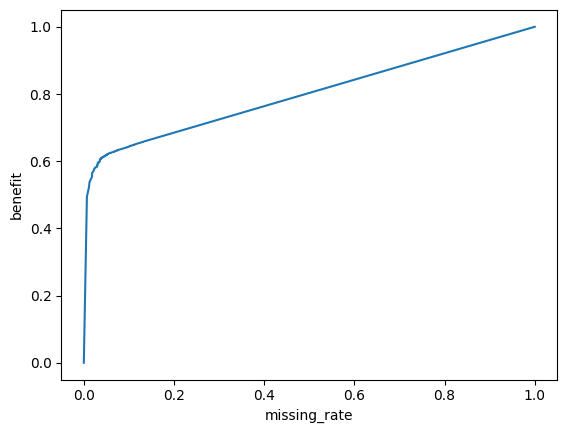

In [ ]:
valid_label = [valid_set[i][1] for i in range(len(valid_set))]

missing_rate, benefit, threshold = we_curve(valid_label, prediction_prob)
plt.plot(missing_rate, benefit)
plt.xlabel('missing_rate')
plt.ylabel('benefit')
plt.show()

In [ ]:
print(missing_rate[:10])
print(benefit[:10])
print(threshold[:10])

[0.0, 0.00684931506849315, 0.01141552511415525, 0.012557077625570776, 0.01598173515981735, 0.0182648401826484, 0.0182648401826484, 0.0182648401826484, 0.0182648401826484, 0.02054794520547945]
[0.0, 0.49460431654676257, 0.5224820143884892, 0.5373201438848921, 0.5476618705035972, 0.5535071942446043, 0.5593525179856115, 0.5616007194244604, 0.5642985611510791, 0.5687949640287769]
[0.    0.001 0.002 0.003 0.004 0.005 0.006 0.007 0.008 0.009]


In [ ]:
pred_label = [1 if x[1] >= 0.001 else 0 for x in prediction_prob_efficientnet] # prediction_prob_resnet50, prediction_prob_efficientnet
true_label = test_df['label2'].tolist()
cm = confusion_matrix(true_label, pred_label) # left: true, up: pred
TN, FP, FN, TP = cm.ravel()
missing_rate = FN / (TP+FN)
benefit = (FN+TN) / (TP+FP+FN+TN)
acc = (TP+TN) / (TP+FP+FN+TN)
print('confusiuon matrix:\n', cm)
print(f'missing_rate: {missing_rate:.5f}')
print(f'benefit: {benefit:.5f}')
print(f'accuracy:, {acc: 5f}')

confusiuon matrix:
 [[1140  384]
 [   4  890]]
missing_rate: 0.00447
benefit: 0.47312
accuracy:,  0.839537


In [ ]:
pred_label_resnet50 = [1 if x[1] >= 0.001 else 0 for x in prediction_prob_resnet50] # change threshold to 0.001
pred_label_efficientnet = [1 if x[1] >= 0.001 else 0 for x in prediction_prob_efficientnet]

pred_label_ensemble = []
for x, y in zip(pred_label_resnet50, pred_label_efficientnet):
  if (x==0 and y==0):
    pred_label_ensemble.append(0)
  else:
    pred_label_ensemble.append(1)

In [ ]:
cm = confusion_matrix(true_label, pred_label_ensemble) # left: true, up: pred
TN, FP, FN, TP = cm.ravel()
missing_rate = FN / (TP+FN)
benefit = (FN+TN) / (TP+FP+FN+TN)
acc = (TP+TN) / (TP+FP+FN+TN)
print('confusiuon matrix:\n', cm)
print(f'missing_rate: {missing_rate:.5f}')
print(f'benefit: {benefit:.5f}')
print(f'accuracy:, {acc: 5f}')

confusiuon matrix:
 [[935 589]
 [  1 893]]
missing_rate: 0.00112
benefit: 0.38710
accuracy:,  0.755997


# Visualization

In [ ]:
print(len(true_label))
print(len(pred_label))

2418
2418


In [ ]:
FN_index = [x==1 and y==0 for x, y in zip(true_label, pred_label_ensemble)]
FN_fname_lst = list(test_df.iloc[FN_index]['compid']+'.jpg')

# FP_index = [x==0 and y==1 for x, y in zip(true_label, pred_label)]
# FP_fname_lst = list(test_df.iloc[FP_index]['compid']+'.jpg')

In [ ]:
path = '/content/drive/MyDrive/Colab Notebooks/task23/task2_task3/testing/pic_task2/'
for fname in FN_fname_lst: # NG->ok
    print(fname)
    image = Image.open(os.path.join(path, fname))
    image.show()